In [2]:
# %load /Users/wayment/ipynb_defaults.py
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import sys

CURRDATE='30aug2025'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
tt= pd.read_json('RelaxDB_pre_fitting_02aug2025.json.zip')

for col in tt.columns:
    if isinstance(tt[col].iloc[0],list):
        tt[col] = [np.asarray(x,dtype=float) for x in tt[col]]

print(len(tt))

194


In [4]:
def iqr(x):
    if len(x)>0:
        return np.percentile(x,75)-np.percentile(x,25)
    else:
        return 999
    
def boost_errs(row):
    dat = row['R2_R1_err'].copy()
    boosted_err = 0.05 * np.abs(row['R2_R1'])
    ma = dat < boosted_err
    dat[ma] = boosted_err[ma]
    return dat

def fit_calculated_R2R1_(row, exclude_low_NOE=False):
    #first pass: calc C for all residues, excluding low NOE
    
    if exclude_low_NOE:
        ma = ~np.isnan(row['R2_R1']) & ~np.isnan(row['raw_R2_R1_pred']) & (row['NOE']>=0.65)
    else:
        ma = ~np.isnan(row['R2_R1']) & ~np.isnan(row['raw_R2_R1_pred'])
        

    C = np.dot(row['R2_R1'][ma],row['raw_R2_R1_pred'][ma])/np.dot(row['raw_R2_R1_pred'][ma],row['raw_R2_R1_pred'][ma])
    dR2R1 = row['R2_R1'] - C * row['raw_R2_R1_pred'] 
    
    # next: do again, excluding low NOE and where dR2R1 > iqr
    ma2 = ma.copy() & (np.abs(dR2R1) < iqr(dR2R1[ma]))
    C = np.dot(row['R2_R1'][ma2],row['raw_R2_R1_pred'][ma2])/np.dot(row['raw_R2_R1_pred'][ma2],row['raw_R2_R1_pred'][ma2])
    dR2R1 = row['R2_R1'] - C * row['raw_R2_R1_pred']
    
    # set outliers as where residual - expt error - est. error of model > 0
    threshold = iqr(dR2R1[ma])
    outliers = dR2R1 - row['R2_R1_err'] - threshold > 0
    
    #enforce must be greater than 0.25
    outliers[dR2R1<0.25] = False
        
    # for calculating RMSE of fit
    inliers = np.zeros_like(dR2R1).astype(bool)
    inliers[np.isnan(row['R2_R1'])] = False
    inliers[np.isnan(row['raw_R2_R1_pred'])] = False
    inliers[dR2R1<=threshold] = True
    inliers[row['NOE']<0.65] = False
    
    rmse = np.sqrt(np.mean(np.square(dR2R1[inliers])))/np.nanmean(row['R2_R1'])

    return C, dR2R1, outliers, rmse, threshold, exclude_low_NOE

def fit_calculated_R2R1(row):
    _, _, _, rmse_incl_lowNOE, _, _ = fit_calculated_R2R1_(row, exclude_low_NOE=False)
    _, _, _, rmse_toss_lowNOE, _, _ = fit_calculated_R2R1_(row, exclude_low_NOE=True)
    if rmse_incl_lowNOE < rmse_toss_lowNOE:
        return fit_calculated_R2R1_(row, exclude_low_NOE=False)
    else:
        return fit_calculated_R2R1_(row, exclude_low_NOE=True)


In [5]:
def assign_labels(row):

    label_list = ''
    NOE_cutoff = 0.65

    for i, val in enumerate(row['sequence']):
        
        if val=='P':
            label_list+='p'
        elif row['missing_peaks'][i] =='.':
            label_list+='.'
        elif row['outliers'][i] and (row['NOE'][i] > NOE_cutoff or pd.isna(row['NOE'][i])):
            label_list+='^'
        elif row['outliers'][i] and row['NOE'][i] <= NOE_cutoff:
            label_list +='b'
        elif row['NOE'][i] <= NOE_cutoff:
            label_list+='v'

        elif np.isnan(row['raw_R2_R1_pred'][i]):
            label_list +='t' # not estimated in rigid calc
        elif np.isnan(row['dR2R1'][i]) and row['missing_peaks'][i] == 'A':
            label_list+='x' # peak present but no R1/R2 data
            
        else:
            label_list+='A'
            
    if row['entry_ID']=='MK12': #from peter wright model-free
        label_list='...pppAAAbb^^vbvxbvvvbb.vbvvbbApxxxv.vxxxbvA^bvvxbbvxxxx^vb^pAbxxxxvvv............vAAvbvvv.xxApvvvxbvbbx.....pvvxvv^xbxvxvvxvbvxxvAbv.b.....xxx.xxvvxx.....pxvbxbvbvbbvvxx.vb.vvxxvxvvxxAbx..xx..px.x.....xxx^.xb..vxxxx^..bbvAv....x..x^vxxxx..bxvxppbvbxbv^.....vvvvvvvpvvvvvxbbvxbxvvbpvAAvvv.x..x^vxxvvvbxvvx^vxpvxbvxbvxvvvpvvvvbbbvvAvvvvvvvxvxxxxxxvxvvxxppxxxxxxxxxxxpx'
        assert len(label_list) == len(row['sequence'])
        
    return label_list

# Use max field strength for labels
tt = tt.sort_values('field_strength',ascending=False)
tt = tt.drop_duplicates('entry_ID')

#increase small exp error bars
tt['R2_R1_err'] = tt.apply(lambda row: boost_errs(row), axis=1)
    
tt[['C','dR2R1','outliers', 'rmse','threshold','exclude_low_NOE']] = tt.apply(lambda row: fit_calculated_R2R1(row),axis=1,result_type='expand')

tt['label'] = tt.apply(lambda row: assign_labels(row),axis=1)

tt.to_json(f'RelaxDB_all_field_strengths_{CURRDATE}.json.zip')

dd = tt.copy()
dd.index = dd['entry_ID']
dd = dd.drop(columns='index')

print(dd['rmse'].mean())

incl_phos = [5841,7036,15255,15795,16392,17783,27011,50410,'ATS','PCF11',17306,
      'PI3KSH2','HMG1A','HMG1B','FKBP','DBD82','MLC1PN','MLC1PC','CHEA','CHEAYBD','GPIIA']

dd['phos'] = dd.apply(lambda row: row['entry_ID'] in incl_phos, axis=1)

dd.to_json(f'RelaxDB_161x_UNFILTERED_{CURRDATE}.json.zip')

f = dd.loc[dd.Filter==1]
print(len(dd))
f.index = [str(x) for x in f.index]
f.to_json(f'RelaxDB_133x_{CURRDATE}.json.zip')

/Users/wayment/opt/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wayment/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/dz/yxswm4nd5gn8qr7s1_h0x71r0000gn/T/ipykernel_98920/792380865.py:23: RuntimeWarning: invalid value encountered in double_scalars
  C = np.dot(row['R2_R1'][ma],row['raw_R2_R1_pred'][ma])/np.dot(row['raw_R2_R1_pred'][ma],row['raw_R2_R1_pred'][ma])
/var/folders/dz/yxswm4nd5gn8qr7s1_h0x71r0000gn/T/ipykernel_98920/792380865.py:28: RuntimeWarning: invalid value encountered in double_scalars
  C = np.dot(row['R2_R1'][ma2],row['raw_R2_R1_pred'][ma2])/np.dot(row['raw_R2_R1_pred'][ma2],row['raw_R2_R1_pred'][ma2])


0.10782709843055087
160


In [6]:
f.loc[~f.phos].sort_values('rmse',ascending=False)[:10]['entry_ID'].values

array(['MK12', 'CIN1D1', 50233, 'PSD1', 'HGMCSF', 'CDK3', 'RFAHTD', 18306,
       'PLEXINB1', 'IL4'], dtype=object)

In [9]:
val=[]
for _, row in f.iterrows():
    val.append(np.nanmean(row['R2_R1_err']))

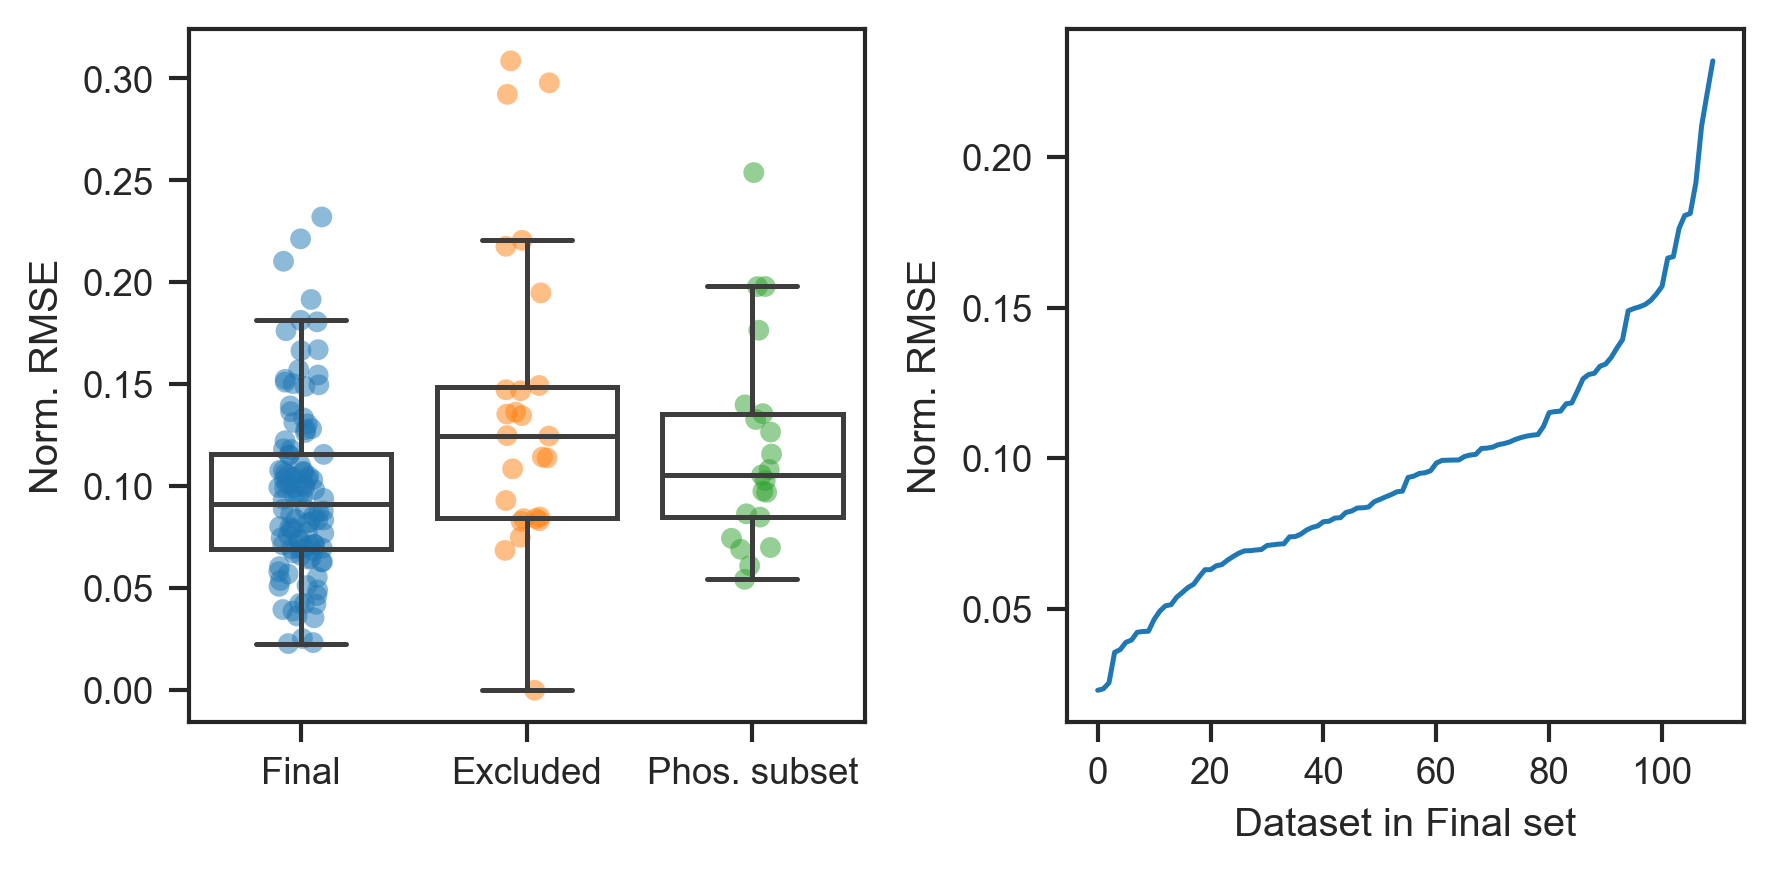

In [10]:
figure(figsize=(6,3))

subplot(1,2,1)

def jitterbox(**kwargs):
    'supply x, y, hue, data'
    sns.stripplot(**kwargs, dodge=True, alpha=0.5,zorder=0)
    ax = sns.boxplot(**kwargs, dodge=True, fliersize=0, zorder=10, boxprops = dict(facecolor=(0,0,0,0)))

    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1, 1), frameon=False)
    
tmp = dd.copy()
tmp = tmp.loc[tmp.entry_ID!='MK12']

tmp['cat'] = tmp.apply(lambda row: 'Filt'+str(row['Filter'])+'_phos' + str(row['phos']),axis=1)
jitterbox(x='cat',y='rmse',data=tmp,order=tmp.cat.unique()[[1,2,0]])

xticks(range(3),['Final','Excluded','Phos. subset'])
xlabel('')
ylabel('Norm. RMSE')

subplot(1,2,2)
plot(sorted(tmp.loc[tmp.cat=='Filt1_phosFalse'].rmse.values))
xlabel('Dataset in Final set')
ylabel('Norm. RMSE')

tight_layout()
savefig(f'rmse_distn_{CURRDATE}.pdf',bbox_inches='tight')

In [11]:
! open -a "Adobe Illustrator" rmse_distn_30aug2025.pdf

In [16]:
print(len(tmp.loc[tmp.cat=='Filt1_phosFalse'][tmp.rmse<.2]))
print(len(tmp.loc[tmp.cat=='Filt1_phosFalse']))

107
111


/var/folders/dz/yxswm4nd5gn8qr7s1_h0x71r0000gn/T/ipykernel_98920/3839633069.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(tmp.loc[tmp.cat=='Filt1_phosFalse'][tmp.rmse<.2]))


In [17]:
print(tmp.loc[tmp.cat=='Filt1_phosFalse'].rmse.mean())

0.09690703282850684

# Plot

In [60]:
def plot_relaxdb_labels(row, data_type='R2_R1',ymin=None,ymax=None, orange_only=False):
    plot(np.arange(row['seq length']), row[data_type],color='black',zorder=5,linewidth=0.5) 
    if data_type=='R2_R1':
        plot(np.arange(row['seq length']), row['C']*row['raw_R2_R1_pred'],color='grey',zorder=5) 

    ax = gca()
    if ymin is None and ymax is None:
        ymin, ymax = ax.get_ylim()
    else:
        ylim([ymin,ymax])
        
    p_pos = ymin + 0.05*(ymax - ymin)
    star_pos = ymin + 0.9*(ymax - ymin)

    for j, char in enumerate(row['sequence']):
        if char=='P':
            axvline(j, color='tab:purple',alpha=0.5, linewidth=0.5)
            text(j-0.5, p_pos,'P', color='tab:purple',fontsize=5,weight='bold')

        elif row['missing_peaks'][j]=='.':
            axvline(j, color='tab:red',alpha=0.5, linewidth=0.5)
            scatter([j],[star_pos],marker='*', color='tab:red')

        if (row['label'][j] == '^' or row['label'][j] == 'b') and not data_type=='NOE':
            errorbar(j,row[data_type][j],yerr=row[data_type+'_err'][j], color='tab:orange',zorder=10, fmt='.')

        if row['label'][j] =='v' and not orange_only:
            errorbar(j,row[data_type][j],yerr=row[data_type+'_err'][j], color='tab:blue',zorder=10, fmt='.')

        if row['label'][j] == 'A':
            errorbar(j,row[data_type][j],yerr=row[data_type+'_err'][j], color='black',zorder=10, fmt='.')
            
        if row['label'][j] == 't':
            errorbar(j,row[data_type][j],yerr=row[data_type+'_err'][j], color='grey',zorder=10, fmt='.')
            
        if row['label'][j] == 'x':
            axvline(j, color='grey',alpha=0.5, linewidth=0.5)
            
    xlim([-1,row['seq length']+1])

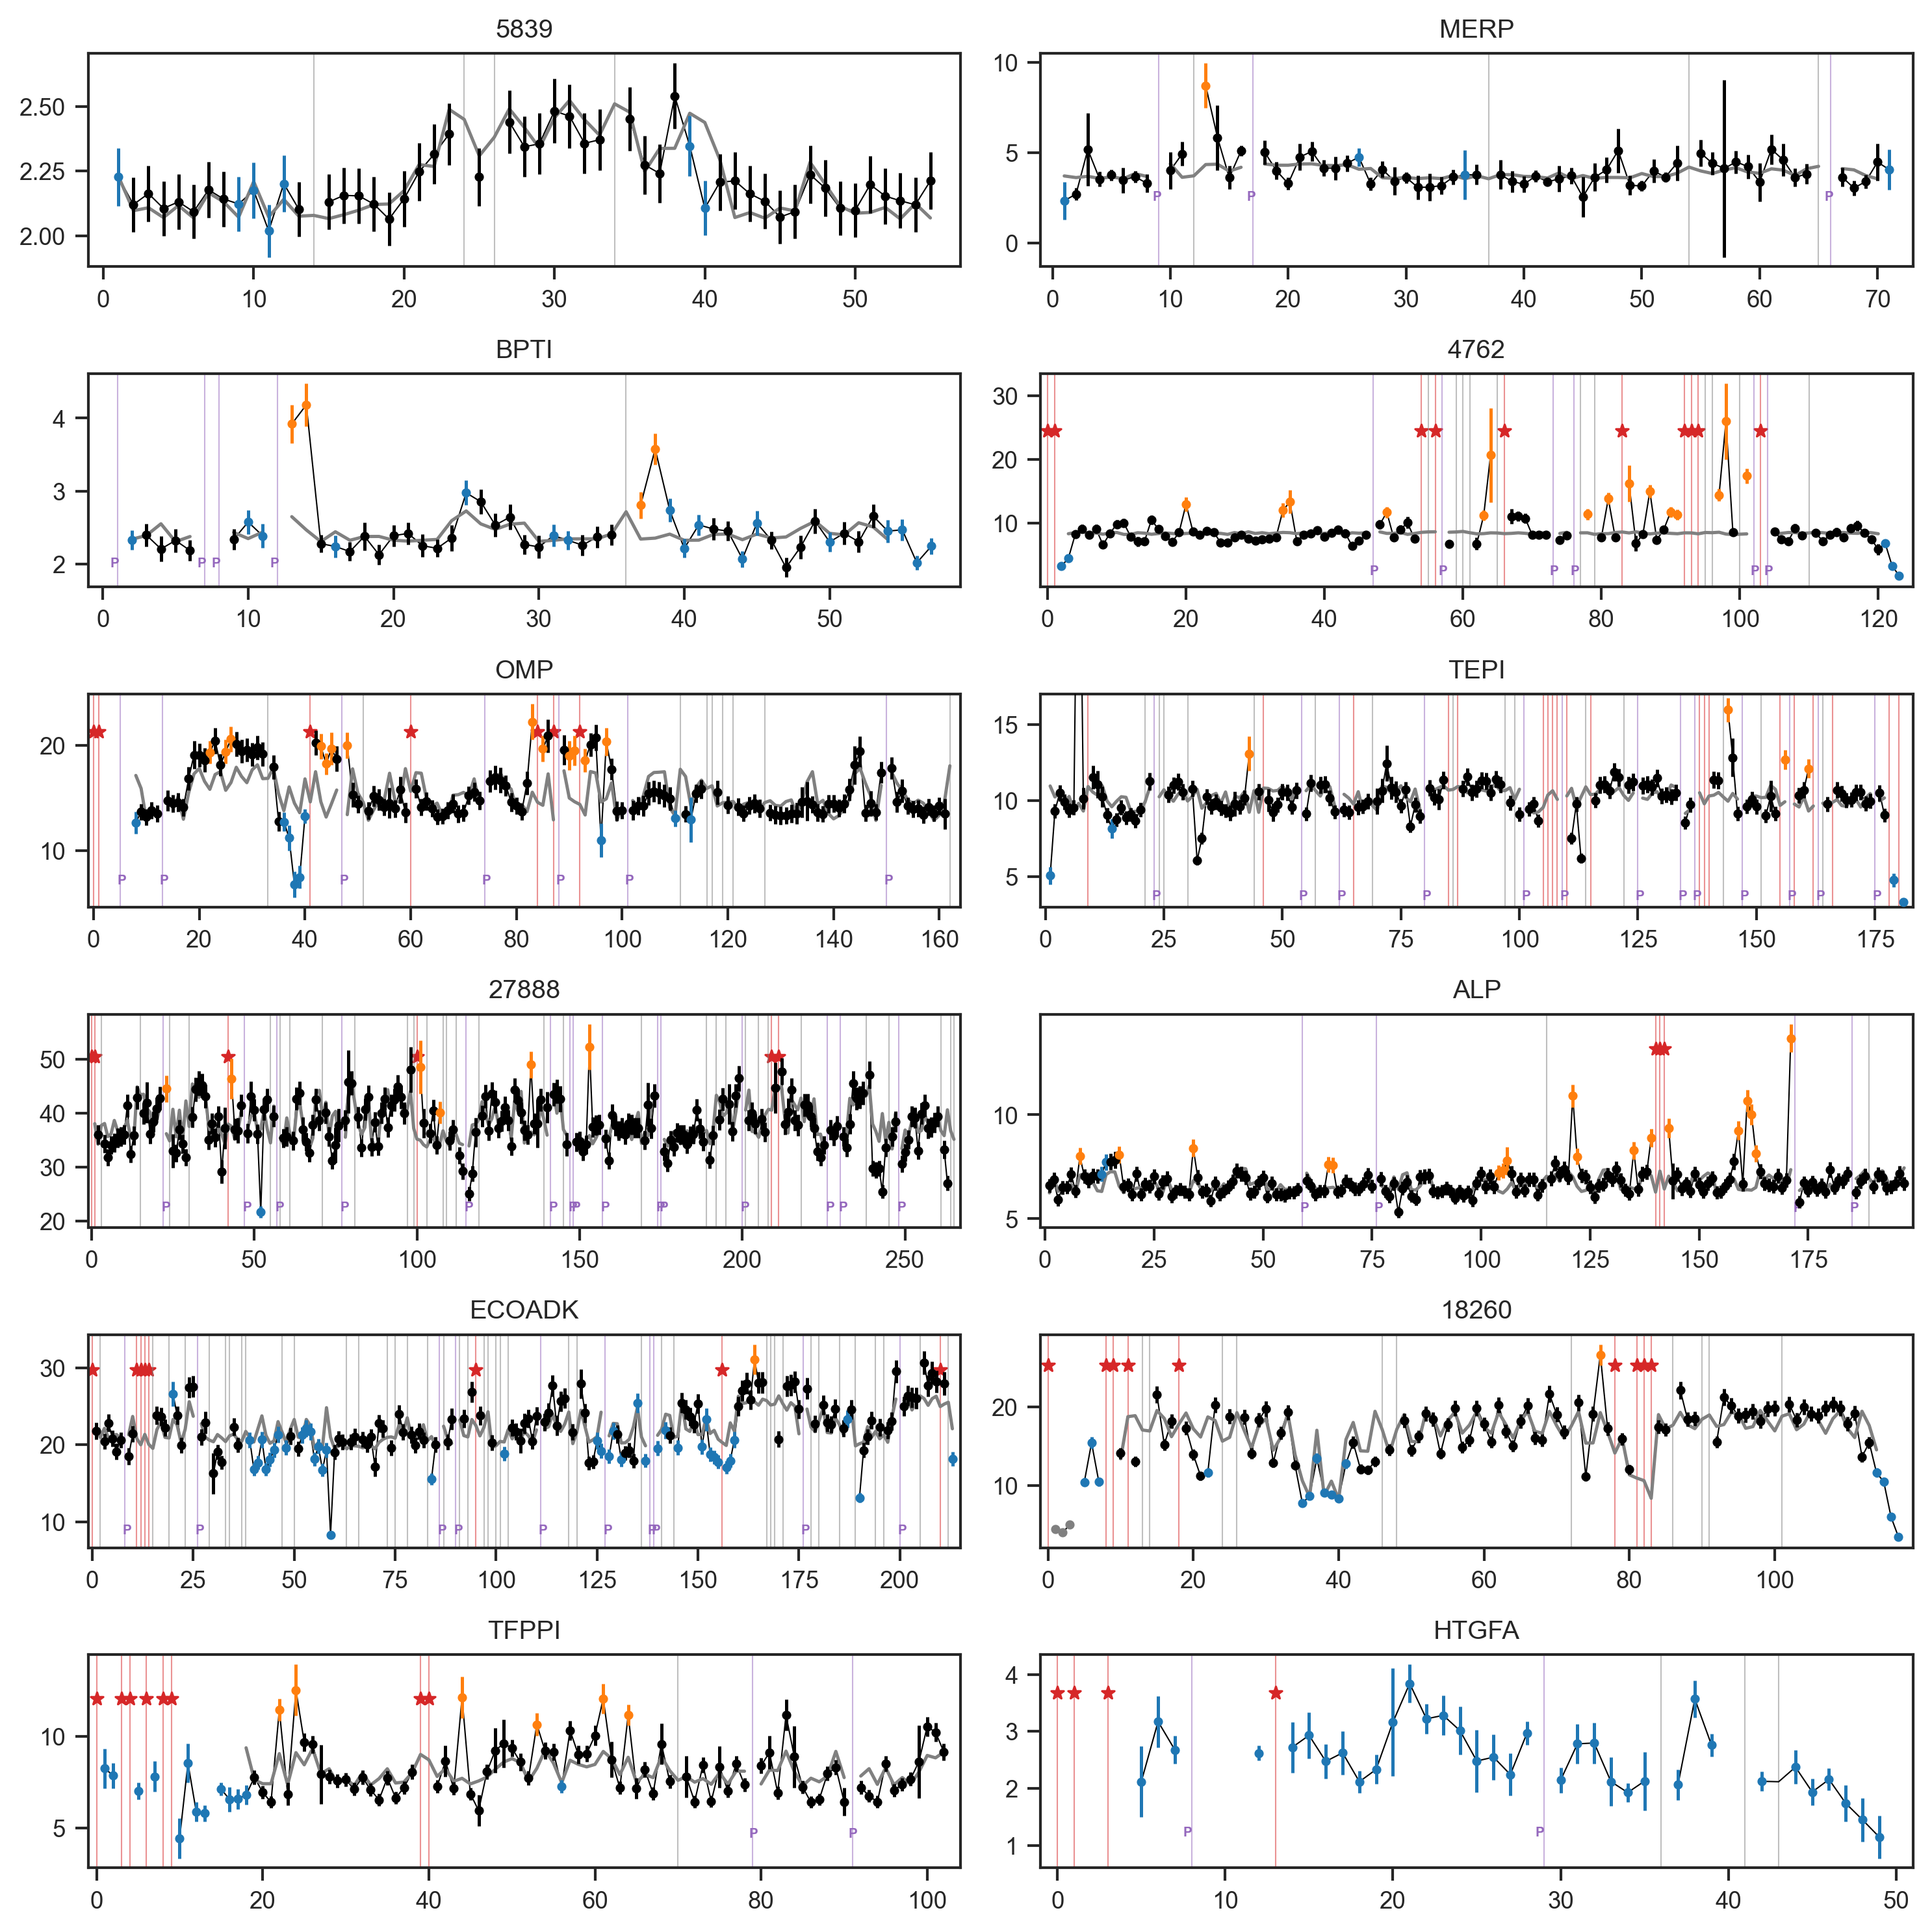

In [88]:

subset=[5839,'MERP','BPTI',4762,'OMP','TEPI',27888,'ALP','ECOADK',18260,'TFPPI']

nrows,ncols = 2,6
figure(figsize=(10,10))

for i,eid in enumerate(subset):
    
    subplot(ncols,nrows,i+1)
    plot_relaxdb_labels(dd.loc[eid]) 
    #title("%s: RMSE no dynamics label: %.2f" % (eid, dd.loc[eid]['rmse']))
    title(eid)
    if eid=='TEPI':
        ylim([3,17])

tight_layout()
savefig(f'RelaxDB_labels_subset_{CURRDATE}_ex2.pdf')

In [71]:
! open figures/

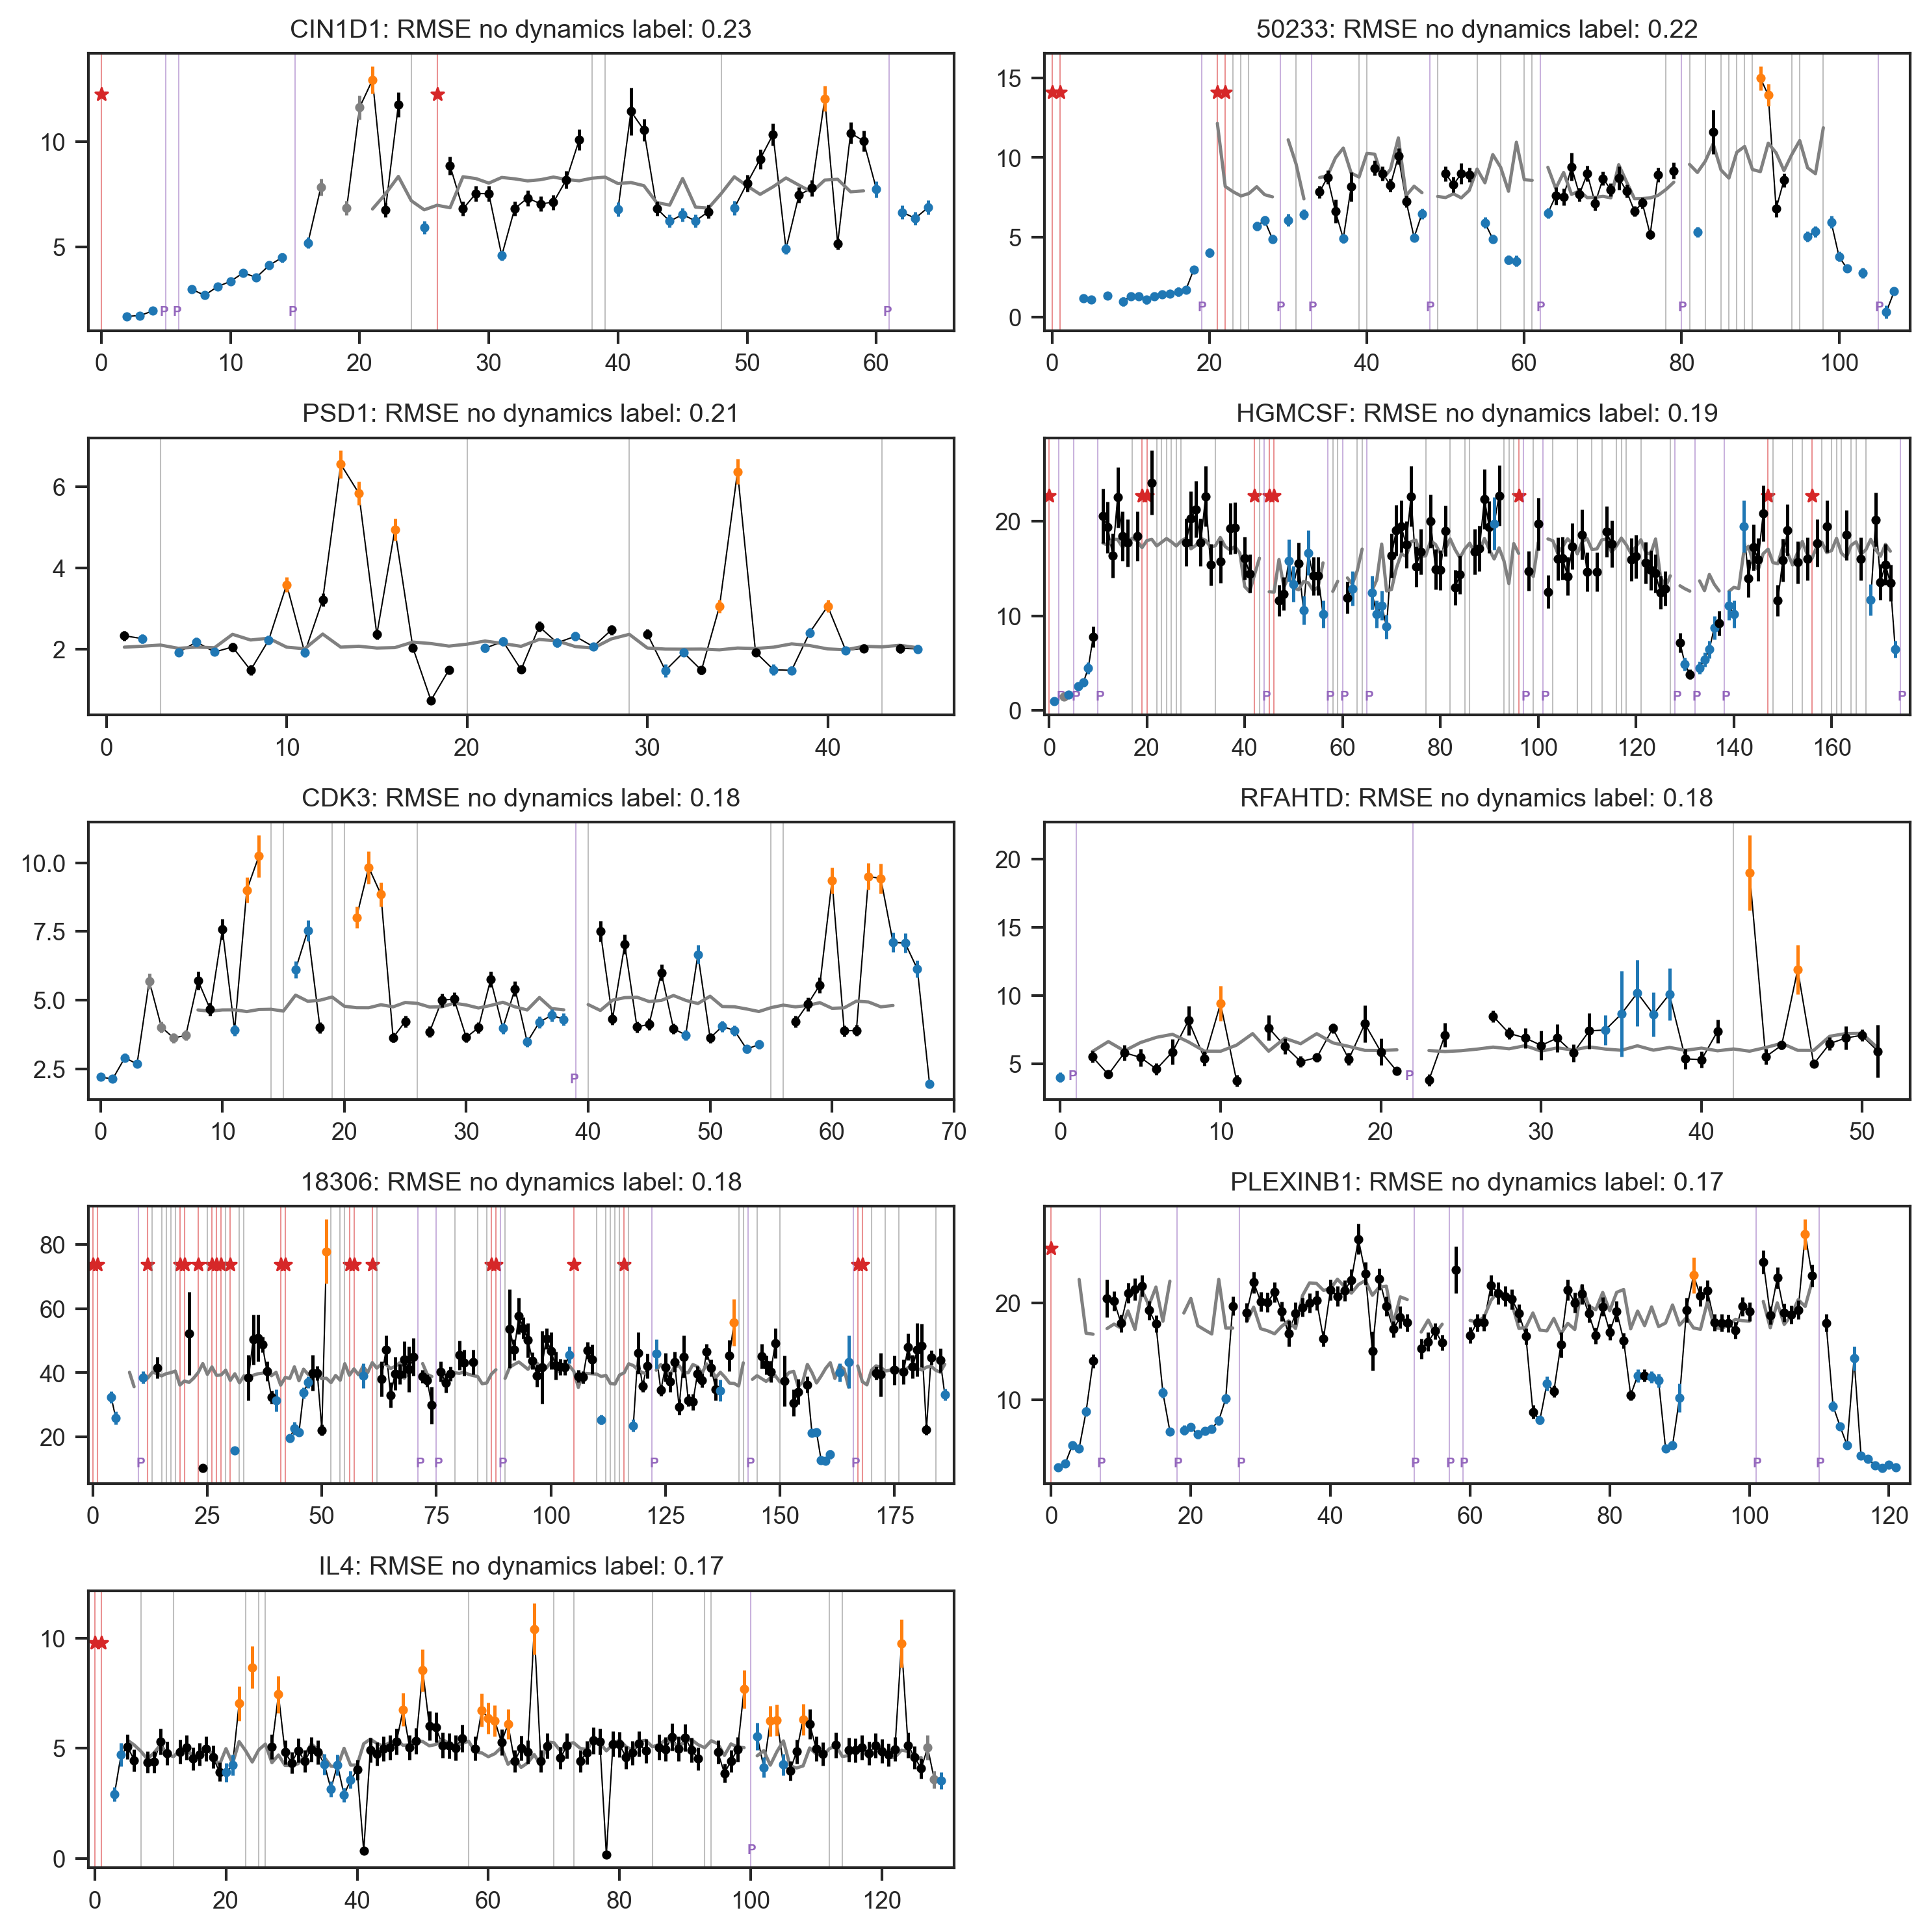

In [78]:
subset = ['CIN1D1', 50233, 'PSD1', 'HGMCSF', 'CDK3', 'RFAHTD', 18306,'PLEXINB1', 'IL4']
nrows,ncols = 2,5
figure(figsize=(10,10))

for i,eid in enumerate(subset):
    
    subplot(ncols,nrows,i+1)
    plot_relaxdb_labels(dd.loc[eid]) 
    title("%s: RMSE no dynamics label: %.2f" % (eid, dd.loc[eid]['rmse']))
    if eid=='TEPI':
        ylim([0,20])

tight_layout()
savefig(f'figures/RelaxDB_labels_subset_worst_RMSE_{CURRDATE}.pdf')

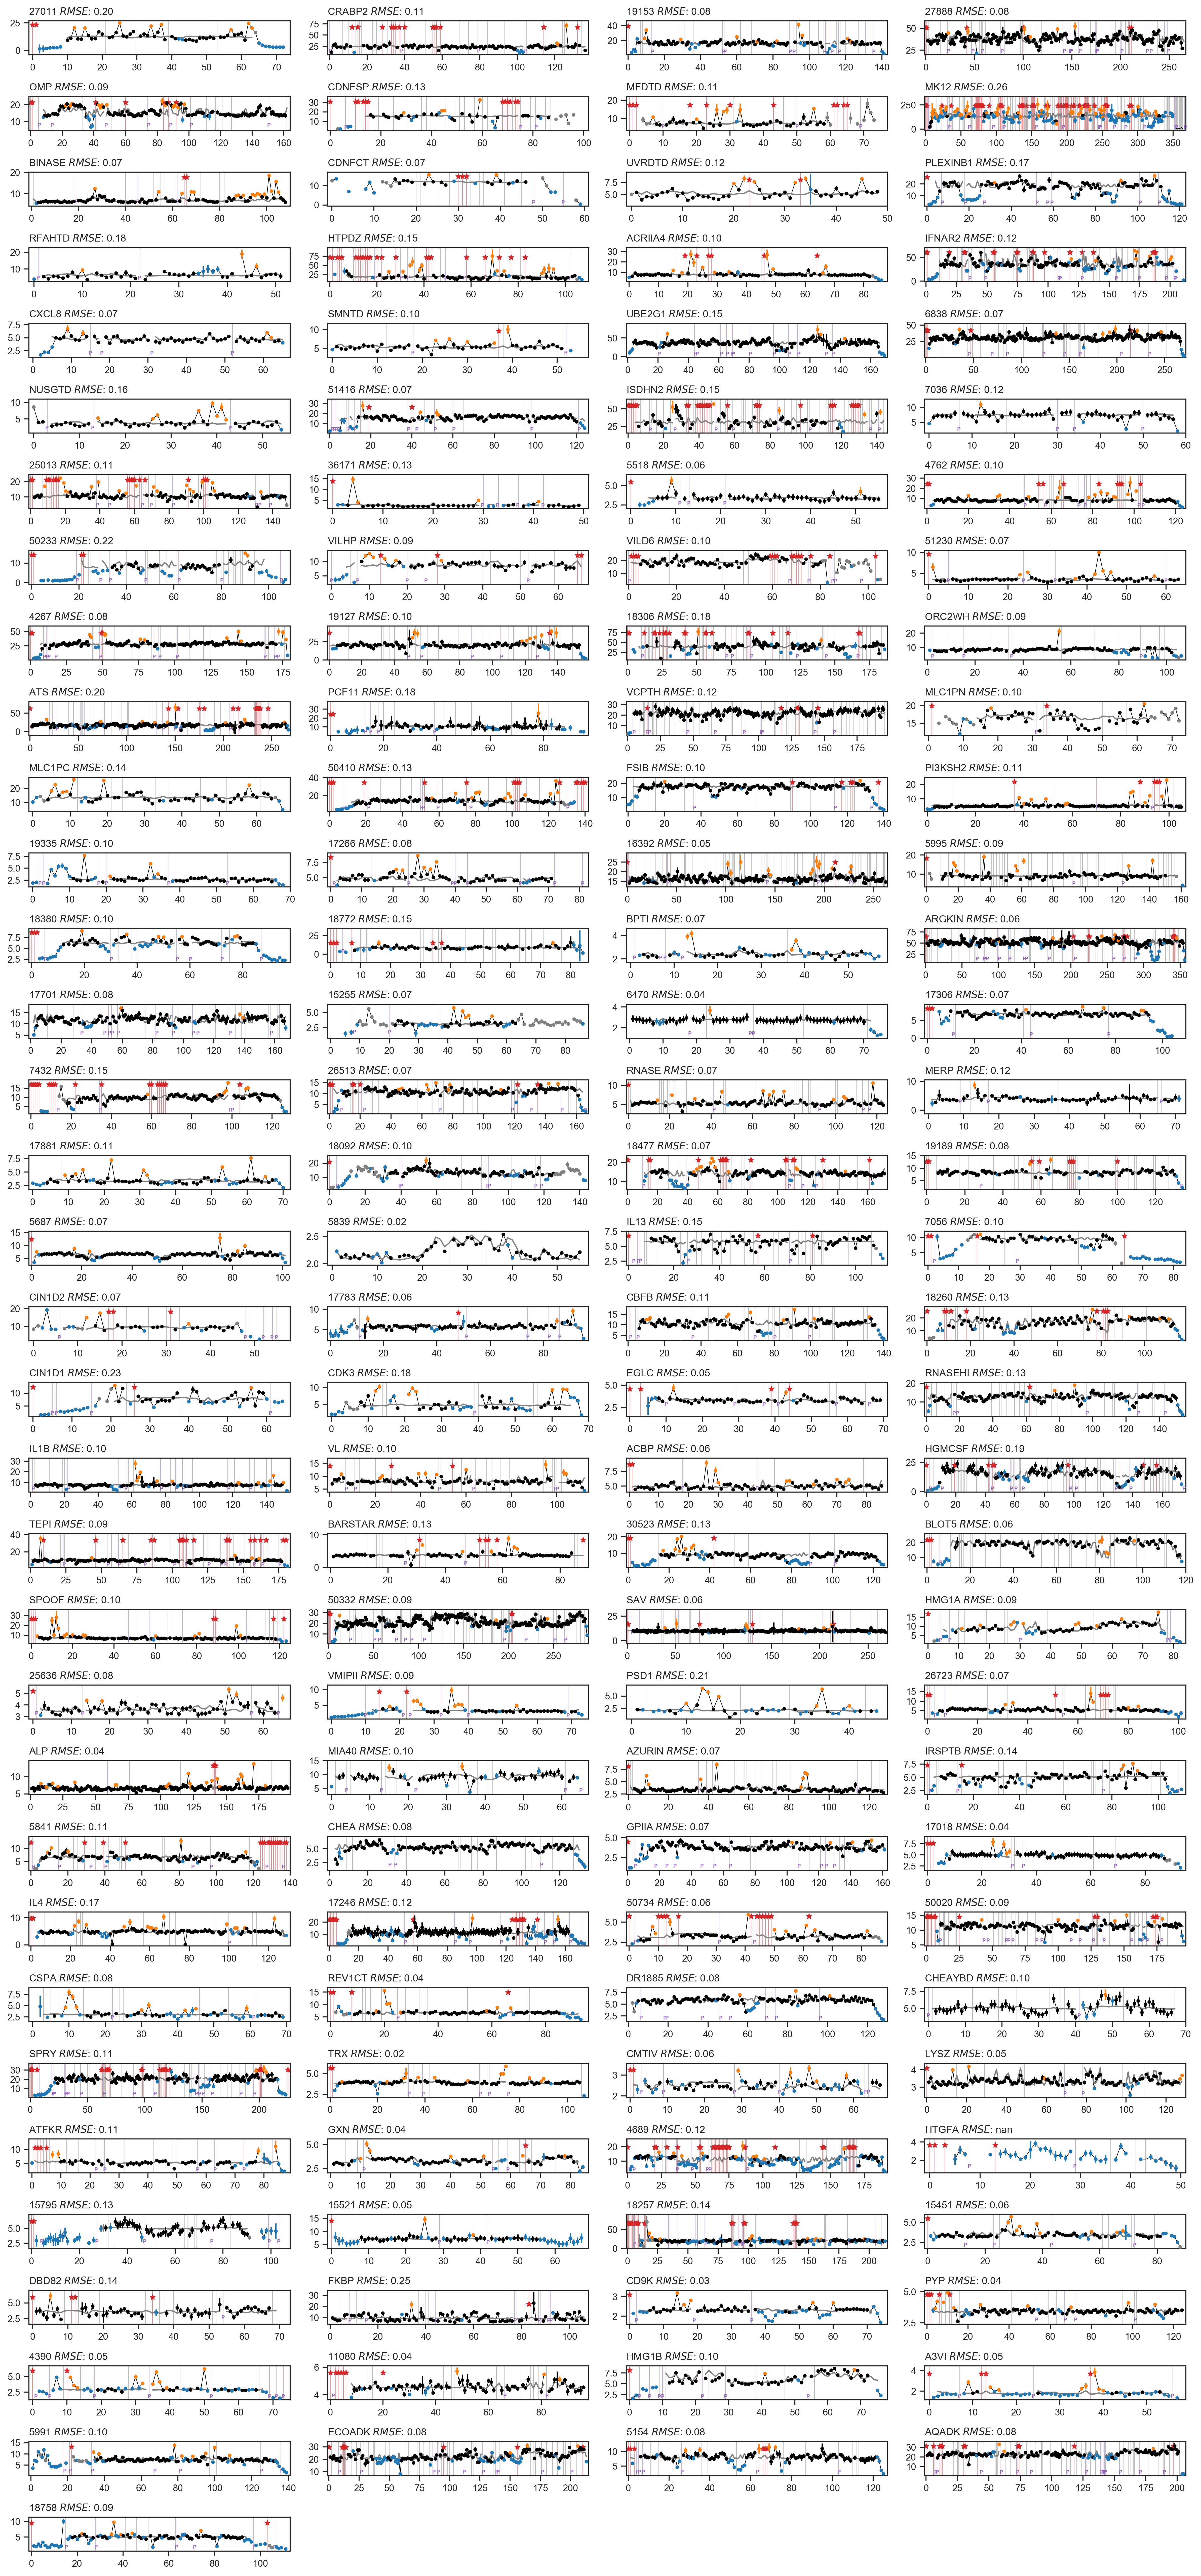

In [51]:
figure(figsize=(16,40))
i=1


dd = pd.read_json(f'RelaxDB_161x_UNFILTERED_{CURRDATE}.json.zip')
for col in dd.columns:
    if isinstance(dd[col].iloc[0],list):
        dd[col] = [np.asarray(x,dtype=float) for x in dd[col]]

dd['entry_ID'] = [str(x) for x in dd['entry_ID']]
for _, row in dd.loc[dd.Filter==1].iterrows():
    subplot(40,4,i)
    title(row['entry_ID']+r' $RMSE$: %.2f' % (row['rmse']),loc='left')
    plot_relaxdb_labels(row)

    i+=1
    
tight_layout()
savefig(f'figures/{CURRDATE}_cutoff.pdf',bbox_inches='tight')


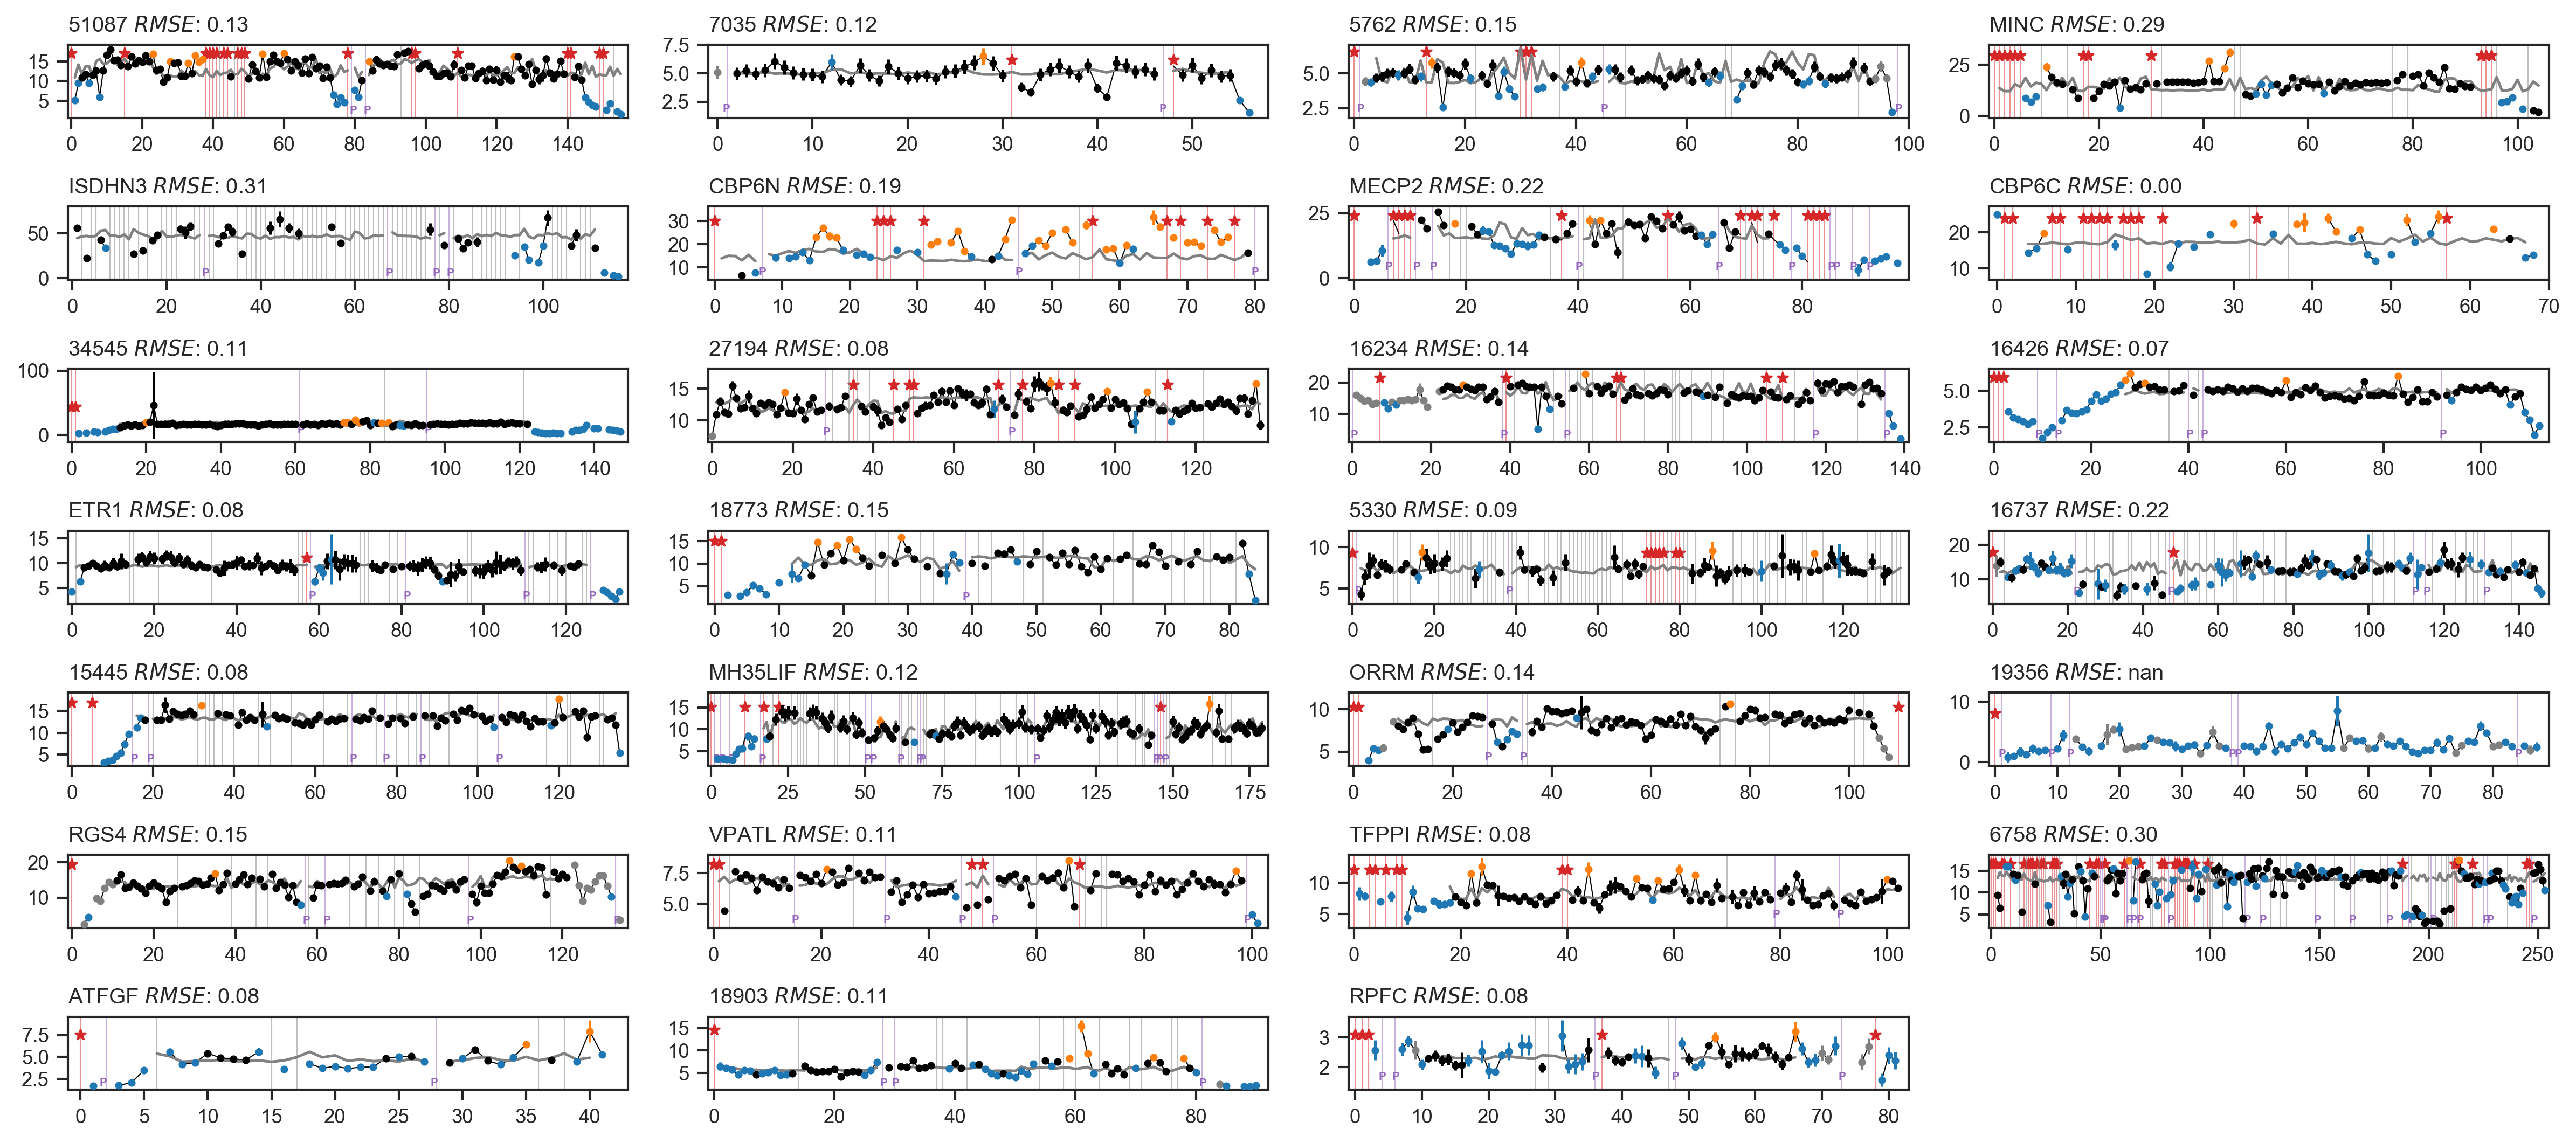

In [52]:
figure(figsize=(16,40))
i=1

for _, row in dd.loc[dd.Filter==0].iterrows():
    subplot(40,4,i)
    title(row['entry_ID']+r' $RMSE$: %.2f' % (row['rmse']),loc='left')
    plot_relaxdb_labels(row)

    i+=1
    
tight_layout()
savefig(f'figures/{CURRDATE}_cutoff_Filter0.pdf',bbox_inches='tight')


In [80]:
import os
os.makedirs(f'relaxdb_data_{CURRDATE}',exist_ok=True)
import pickle
for _, row in dd.iterrows():
    with open(f"relaxdb_data_{CURRDATE}/{row['entry_ID']}.pkl",'wb') as f:
        pickle.dump({'entry_ID': row['entry_ID'],'sequence': row['sequence'],'label': row['label']},f)


In [81]:
! zip -r relaxdb_pkls_30aug2025.zip relaxdb_data_30aug2025/*

updating: relaxdb_data_30aug2025/11080.pkl (deflated 28%)
updating: relaxdb_data_30aug2025/15255.pkl (deflated 26%)
updating: relaxdb_data_30aug2025/15445.pkl (deflated 33%)
updating: relaxdb_data_30aug2025/15451.pkl (deflated 24%)
updating: relaxdb_data_30aug2025/15521.pkl (deflated 23%)
updating: relaxdb_data_30aug2025/15795.pkl (deflated 28%)
updating: relaxdb_data_30aug2025/16234.pkl (deflated 33%)
updating: relaxdb_data_30aug2025/16392.pkl (deflated 43%)
updating: relaxdb_data_30aug2025/16426.pkl (deflated 32%)
updating: relaxdb_data_30aug2025/16737.pkl (deflated 32%)
updating: relaxdb_data_30aug2025/17018.pkl (deflated 29%)
updating: relaxdb_data_30aug2025/17246.pkl (deflated 38%)
updating: relaxdb_data_30aug2025/17266.pkl (deflated 25%)
updating: relaxdb_data_30aug2025/17306.pkl (deflated 41%)
updating: relaxdb_data_30aug2025/17701.pkl (deflated 38%)
updating: relaxdb_data_30aug2025/17783.pkl (deflated 32%)
updating: relaxdb_data_30aug2025/17881.pkl (deflated 23%)
updating: rela

In [266]:
print(dd.loc[dd.entry_ID=='18477']['label'].iloc[0])

.tttttttttpvvx..AAAAAAAAAAAxvvvvvvxvvvvpvvAAAAA.AAAAAAAA^^AAAA.....AvxAAAAAAxAxAAv.AAAAAAAAAAAAAAAAAAAAAA..pvv..vAxApAAAAAAAvpAvAA.AxAAAAAAAAxAAAAAAAAAAAxAAAAAAA.AvAAAAAAAA
